In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=128,
                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=100,
                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [5]:

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.maxpool1(self.relu1(self.conv1(x)))
        x = self.maxpool2(self.relu2(self.conv2(x)))
        x = self.maxpool3(self.relu3(self.conv3(x)))
        x = self.flatten(x)
        x = self.relu4(self.fc1(x))
        x = self.fc2(x)
        return x

In [6]:

net = Net().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

num_epochs = 10
log_interval = 100
train_losses = []
accuracies_per_class = {c: [] for c in classes}
train_steps = []
current_step = 0

In [7]:
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if (i + 1) % log_interval == 0:
            train_losses.append(running_loss / log_interval)
            train_steps.append(current_step + log_interval)
            running_loss = 0.0

            with torch.no_grad():
                class_correct = list(0. for i in range(10))
                class_total = list(0. for i in range(10))
                outputs = net(inputs)
                _, predicted = torch.max(outputs, 1)
                c = (predicted == labels).squeeze()
                for k in range(labels.size(0)):
                    label_idx = labels[k]
                    class_correct[label_idx] += c[k].item()
                    class_total[label_idx] += 1
                for j in range(10):
                    if class_total[j] > 0:
                        accuracies_per_class[classes[j]].append(class_correct[j] / class_total[j])
                    else:
                        accuracies_per_class[classes[j]].append(0.0) # Avoid division by zero

        current_step += 1
        if (i + 1) % log_interval == 0:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {train_losses[-1]:.3f}')

[1,   100] loss: 1.929
[1,   200] loss: 1.585
[1,   300] loss: 1.462
[2,   100] loss: 1.330
[2,   200] loss: 1.227
[2,   300] loss: 1.201
[3,   100] loss: 1.078
[3,   200] loss: 1.043
[3,   300] loss: 1.017
[4,   100] loss: 0.926
[4,   200] loss: 0.929
[4,   300] loss: 0.905
[5,   100] loss: 0.845
[5,   200] loss: 0.839
[5,   300] loss: 0.812
[6,   100] loss: 0.794
[6,   200] loss: 0.785
[6,   300] loss: 0.761
[7,   100] loss: 0.742
[7,   200] loss: 0.715
[7,   300] loss: 0.717
[8,   100] loss: 0.692
[8,   200] loss: 0.696
[8,   300] loss: 0.680
[9,   100] loss: 0.667
[9,   200] loss: 0.657
[9,   300] loss: 0.653
[10,   100] loss: 0.609
[10,   200] loss: 0.610
[10,   300] loss: 0.645


In [10]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total}%')

correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

print("\nAccuracy per class on the test set:")
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy of the network on the 10000 test images: 77%

Accuracy per class on the test set:
Accuracy for class: plane is 84.3 %
Accuracy for class: car   is 88.3 %
Accuracy for class: bird  is 56.6 %
Accuracy for class: cat   is 60.4 %
Accuracy for class: deer  is 77.0 %
Accuracy for class: dog   is 68.9 %
Accuracy for class: frog  is 76.6 %
Accuracy for class: horse is 86.1 %
Accuracy for class: ship  is 91.5 %
Accuracy for class: truck is 87.4 %


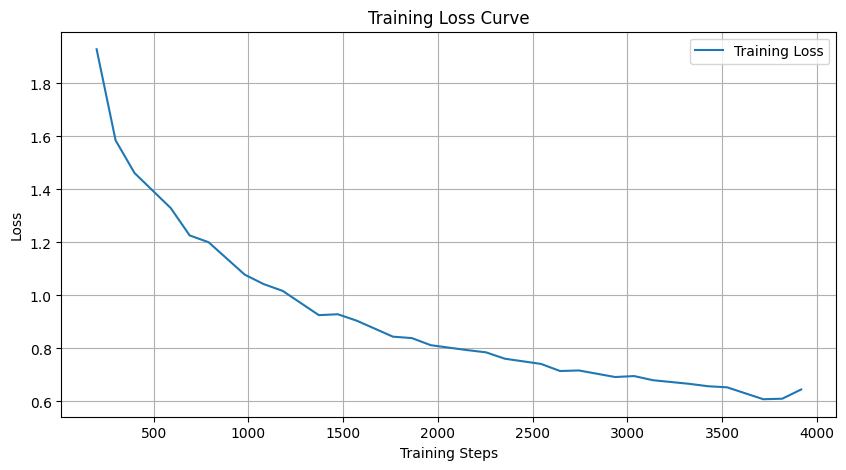

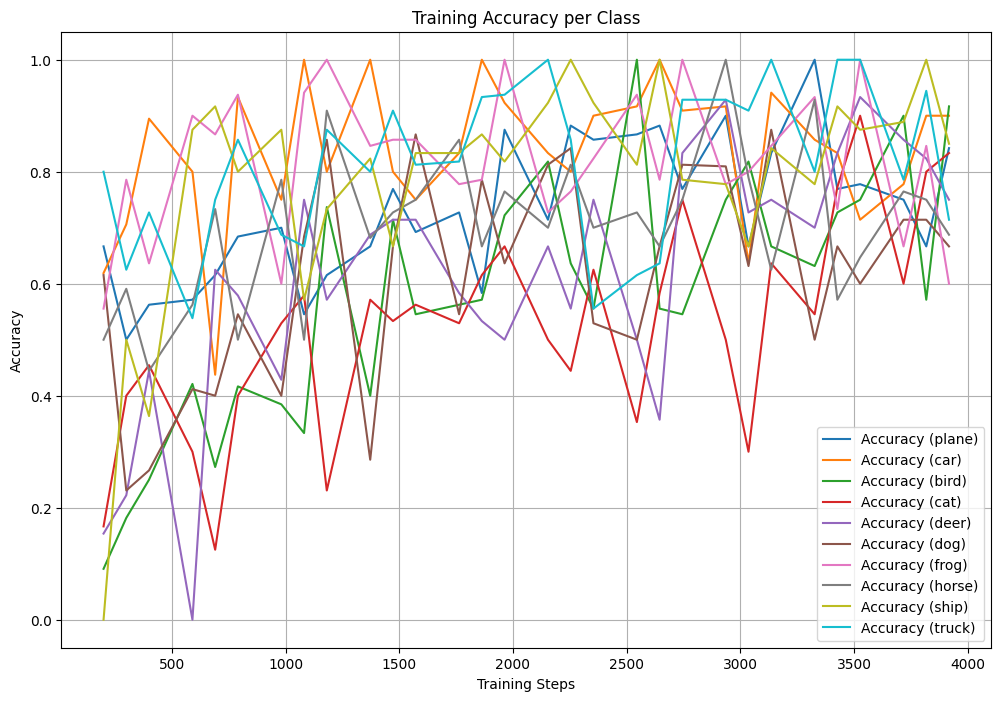

In [11]:

plt.figure(figsize=(10, 5))
plt.plot(train_steps, train_losses, label='Training Loss')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 8))
for class_name, accuracies in accuracies_per_class.items():
    num_points = min(len(train_steps), len(accuracies))
    plt.plot(train_steps[:num_points], accuracies[:num_points], label=f'Accuracy ({class_name})')

plt.xlabel('Training Steps')
plt.ylabel('Accuracy')
plt.title('Training Accuracy per Class')
plt.legend()
plt.grid(True)
plt.show()